In [1]:
import pandas as pd
import gymnasium as gym
import numpy as np

from dist_plot import plot_q_values_map
from dist_q import EpsilonGreedy, Qlearning, QuantileRegression
from dist_run import Params, run_env

from gymnasium.envs.registration import register
from matplotlib import pyplot as plt

register(
    id="CliffCustom-v1",
    entry_point="cliffcustom:CliffCustomEnv",
)

register(
    id="WindyRooms-v1",
    entry_point="windyrooms:WindyRoomsEnv",
)

In [39]:
params = Params(
    total_episodes=20_000,
    learning_rate=0.1,
    gamma=0.95,
    epsilon=0.1,
    map_size=(4, 12),
    seed=123,
    is_slippery=True,
    n_runs=1,
    action_size=None,
    state_size=None,
    n_quantiles=32,
    use_lr_decay=True,
)

rng = np.random.default_rng(params.seed)

In [40]:
env = gym.make(
    "CliffCustom-v1",
    is_slippery=params.is_slippery,
    shape=params.map_size,
    render_mode="rgb_array",
)
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
env.action_space.seed(params.seed)

# learner = Qlearning(params.learning_rate, params.gamma, params.state_size, params.action_size)
learner = QuantileRegression(params.learning_rate, params.gamma, params.state_size, params.action_size, params.n_quantiles)
explorer = EpsilonGreedy(params.epsilon, rng)
qtables = run_env(env, learner, explorer, params)

Run 0/1 - Episodes: 100%|██████████| 20000/20000 [01:01<00:00, 325.71it/s]


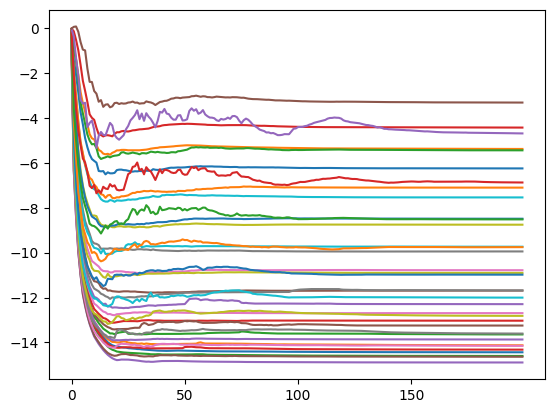

In [41]:
plt.plot(qtables[0,:,:36,0,:].mean(2))
plt.xticks(range(qtables.shape[1])[::50]);

In [42]:
import pygame
import numpy as np

# --- config ---
GRID_SIZE = 80
GRID_W, GRID_H = params.map_size
ACTIONS = [0, 1, 2, 3]  # order: north, east, south, west
FPS = 30

# --- color helper ---
def value_to_color(v, vmin=-1, vmax=1):
    v = max(min(v, vmax), vmin)  # clamp
    if v == 0:
        return (0, 0, 0)
    elif v > 0:
        return (0, int(255 * v / vmax), 0)  # green scale
    else:
        return (int(255 * -v / -vmin), 0, 0)  # red scale

# --- drawing ---
def draw_state(screen, x, y, qvals, vmin, vmax):
    cx, cy = x * GRID_SIZE, y * GRID_SIZE
    half = GRID_SIZE // 2

    triangles = {
        0: [(cx, cy), (cx+GRID_SIZE, cy), (cx+half, cy+half)],
        2: [(cx, cy+GRID_SIZE), (cx+GRID_SIZE, cy+GRID_SIZE), (cx+half, cy+half)],
        1: [(cx+GRID_SIZE, cy), (cx+GRID_SIZE, cy+GRID_SIZE), (cx+half, cy+half)],
        3: [(cx, cy), (cx, cy+GRID_SIZE), (cx+half, cy+half)],
    }

    font = pygame.font.SysFont("Courier", 16, bold=True)
    offsets = {0: (0, -half//2), 2: (0, half//2), 1: (half//2, 0), 3: (-half//2, 0)}

    for a, pts in triangles.items():
        val = qvals[a]
        pygame.draw.polygon(screen, value_to_color(val, vmin, vmax), pts)
        pygame.draw.polygon(screen, (0,0,0), pts, 1)

        ox, oy = offsets[a]
        text = font.render(f"{val:.0f}", True, (255,255,255))
        rect = text.get_rect(center=(cx+half+ox, cy+half+oy))
        screen.blit(text, rect)

pygame.init()
screen = pygame.display.set_mode((GRID_H*GRID_SIZE, GRID_W*GRID_SIZE))
clock = pygame.time.Clock()

# starting index for qtables
qt_index = 0
max_index = qtables.shape[1] - 1

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEWHEEL:
            if event.y > 0:  # wheel up
                qt_index = min(qt_index + 1, max_index)
            elif event.y < 0:  # wheel down
                qt_index = max(qt_index - 1, 0)

    screen.fill((50,50,50))

    qtable = qtables[0,qt_index].mean(-1)
    vmin, vmax = qtable.min(), qtable.max()
    
    for x in range(GRID_W):
        for y in range(GRID_H):
            state = np.ravel_multi_index((x,y), params.map_size)
            qvals = {a: qtable[state,a] for a in ACTIONS}
            draw_state(screen, y, x, qvals, vmin, vmax)

    pygame.display.flip()
    clock.tick(FPS)

pygame.quit()

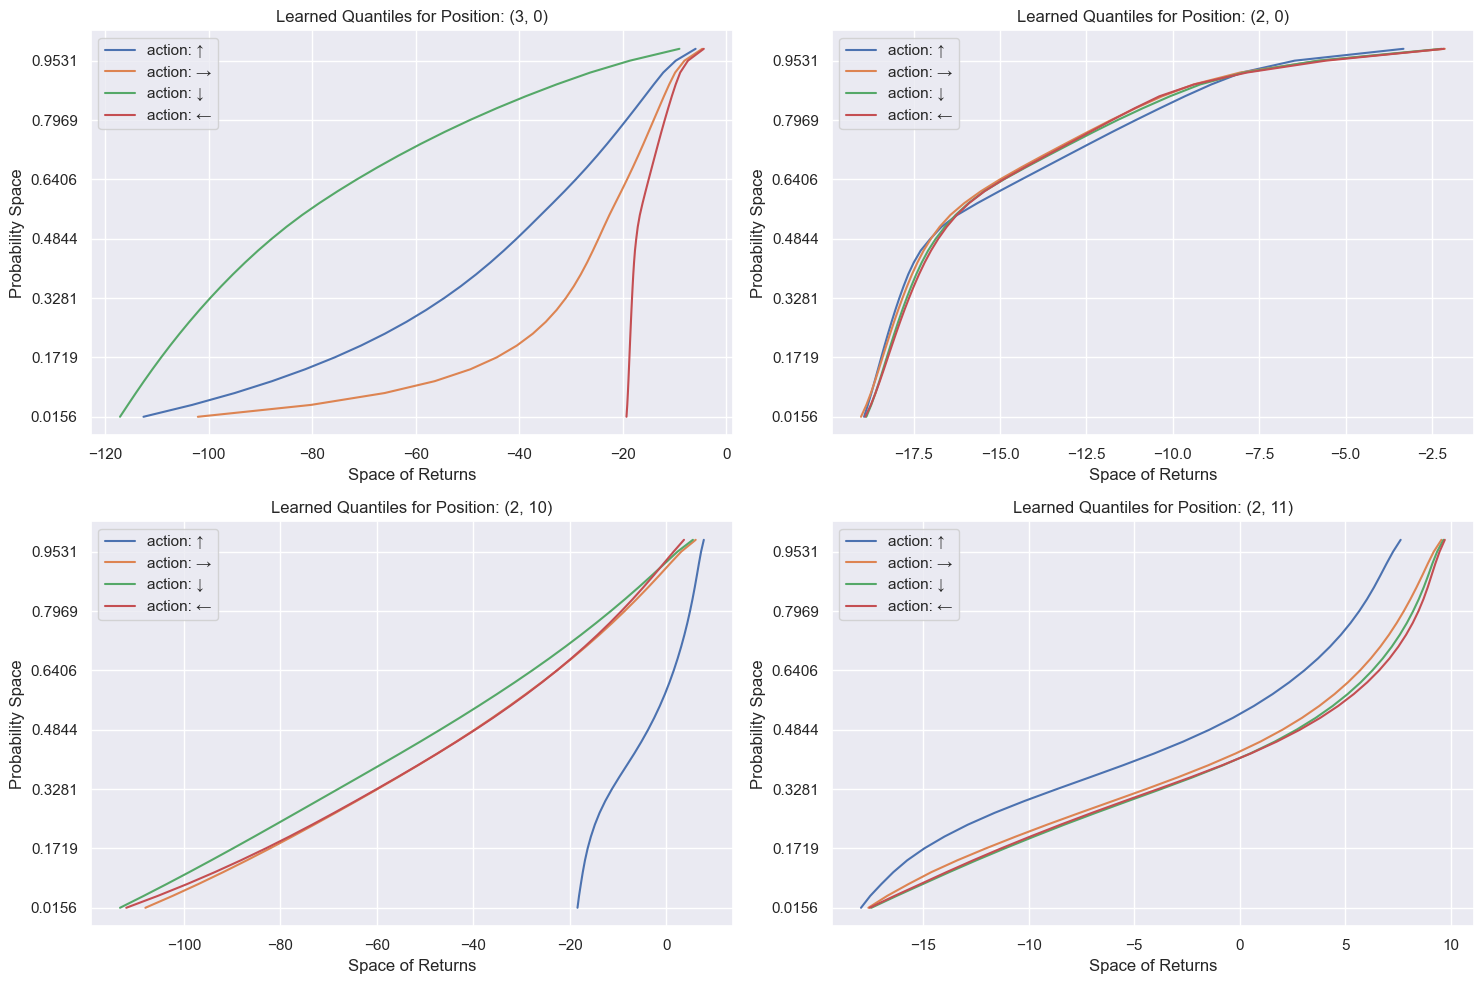

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
tau = ((2 * np.arange(params.n_quantiles) + 1) / (2.0 * params.n_quantiles))
arrow_directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, pos in enumerate([(3, 0), (2, 0), (2, 10), (2, 11)]):
    ax = axes[i]
    state = np.ravel_multi_index(pos, params.map_size)

    for j, quantiles in enumerate(qtables[0,-1,state]):
        ax.plot(quantiles, tau, label=f"action: {arrow_directions[j]}")

    ax.set_title(f"Learned Quantiles for Position: {pos}")
    ax.set_xlabel("Space of Returns")
    ax.set_ylabel("Probability Space")
    ax.set_yticks(tau[::5])
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
for i, pos in enumerate([(3, 0), (2, 0), (2, 10), (2, 11)]):
    state = np.ravel_multi_index(pos, params.map_size)
    print(f"position: {i} | q_value : {qtable.mean(2)[state]}")

position: 0 | q_value : [-47.31481335 -31.8535346  -79.59810001 -15.63245419]
position: 1 | q_value : [-15.15406494 -15.34359933 -15.24815313 -15.25137222]
position: 2 | q_value : [ -4.19043255 -43.29088448 -46.98397113 -44.13987436]
position: 3 | q_value : [-3.35203245 -0.64566268  0.26389967 -0.35698404]


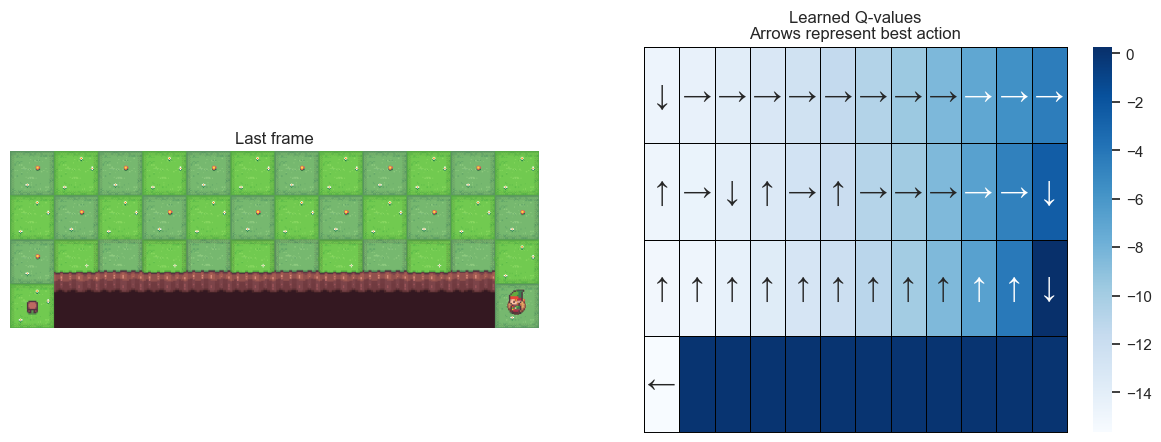

In [6]:
plot_q_values_map(qtable.mean(2), env, params.map_size)